In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import dependencies

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from typing import Optional, Tuple, List

2024-03-01 17:40:07.397707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 17:40:07.397791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 17:40:07.521106: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import random
import cv2
import matplotlib.image as mpimg

from PIL import Image, ImageEnhance
from matplotlib.pyplot import imshow
%matplotlib inline

import torch
import torchvision.transforms as transforms

## Dataloader

# FOR DATASET

In [4]:
data_dir = "/kaggle/input/glaucoma-classification-datasets/RIM-ONE/RIM-ONE/NOT PARTITIONED"
class_folders = os.listdir(data_dir)
if len(class_folders) != 2:
    raise ValueError("There should be exactly two classes in the data directory.")


In [5]:
resize = True

In [6]:
folder_count = len(class_folders)

In [7]:
p1 = []
p2 = []
y = []
z = []

for i in range(folder_count):
        image_files = os.listdir(os.path.join(data_dir, class_folders[i]))
        image_count = len(image_files)
        for j in range(image_count):
            z.append(image_files[j])
            y.append(i)
            
c = 0          
for i in range(folder_count):
    s = os.listdir(os.path.join(data_dir, class_folders[i]))
    t = len(s)
    for j in range(t):
        img_path = os.path.join(data_dir, class_folders[i], z[c])
        #image_count = len(image_files)
        try:
            img = mpimg.imread(img_path, 'rw+')
            
            if resize:
                img = cv2.resize(img, (256, 256))
            if i == 0:
                p1.append(img)
            if i == 1:
                p2.append(img)
        except:
            pass
        c = c + 1

In [8]:
print(c)

485


In [9]:
X = []
for i in range(len(p1)):
    X.append(p1[i])
for i in range(len(p2)):
    X.append(p2[i])

# DO NOT RESIZE TO (0, 1) AS RIMONE IMAGE IS IN PNG

In [10]:
#X = np.array(X) / 255

In [10]:
y = np.array(y).reshape(-1, 1)

In [11]:
# shuffle the lists with same order
zipped = list(zip(X, y))
random.shuffle(zipped)
X, y = zip(*zipped)

In [12]:
X = np.array(X)
y = np.array(y).reshape(-1, 1)

In [68]:
from sklearn.model_selection import KFold

files_for_train_x = []
files_for_validation_x = []
files_for_train_y = []
files_for_validation_y = []

kfold = KFold(n_splits = 5)
for train_index, val_index in kfold.split(X):
    # Split the entire data into 5 folds
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    files_for_train_x.append(X_train)
    files_for_validation_x.append(X_val)
    files_for_train_y.append(y_train)
    files_for_validation_y.append(y_val)

        
print(files_for_train_x[3].shape,files_for_train_y[3].shape,files_for_validation_x[3].shape,files_for_validation_y[3].shape)

(388, 256, 256, 3) (388, 1) (97, 256, 256, 3) (97, 1)


In [69]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
  files_for_train_x[3] , files_for_train_y[3] , random_state=42 ,test_size=0.2, shuffle=True, stratify = files_for_train_y[3])

In [70]:
X_test = files_for_validation_x[3]
y_test = files_for_validation_y[3]


In [71]:
print(X_test.shape,y_test.shape)

(97, 256, 256, 3) (97, 1)


# Augmentation (Train Data) for Dataset

In [72]:
print("Train Data Before Augmentation")
print(X_train.shape,
y_train.shape)

Train Data Before Augmentation
(310, 256, 256, 3) (310, 1)


In [73]:
X_train_aug = X_train.tolist()
y_train_aug = y_train.tolist()

# Data Augmentation

# Data Augmentation of Dataset (Training Images only) (JPG / PNG files)

In [19]:
t1 = transforms.RandomVerticalFlip(p=1)
t2 = transforms.RandomHorizontalFlip(p=1)
t3 = transforms.GaussianBlur(kernel_size = (9, 9), sigma=(2.0, 4.0))
t4 = transforms.RandomRotation(20, interpolation = transforms.InterpolationMode.NEAREST, expand=False, center=None, fill=0)
t5 = transforms.ColorJitter(brightness = [1, 3], contrast = [1, 2], saturation = 0, hue = 0)





In [74]:
l = len(y_train)
for i in range(0, l, 5):
    im1 = X_train_aug[i]
    im2 = X_train_aug[i+1]
    im3 = X_train_aug[i+2]
    im4 = X_train_aug[i+3]
    im5 = X_train_aug[i+4]
    lab1 = y_train_aug[i]
    lab2 = y_train_aug[i+1]
    lab3 = y_train_aug[i+2]
    lab4 = y_train_aug[i+3]
    lab5 = y_train_aug[i+4]
    im1 = np.array(im1)
    im2 = np.array(im2)
    im3 = np.array(im3)
    im4 = np.array(im4)
    im5 = np.array(im5)
    b1 = torch.from_numpy(im1)
    b2 = torch.from_numpy(im2)
    b3 = torch.from_numpy(im3)
    b4 = torch.from_numpy(im4)
    b5 = torch.from_numpy(im5)
    c1 = b1.permute(2, 0, 1)
    c2 = b2.permute(2, 0, 1)
    c3 = b3.permute(2, 0, 1)
    c4 = b4.permute(2, 0, 1)
    c5 = b5.permute(2, 0, 1)
    u1 = t1(c1)
    u2 = t2(c2)
    u3 = t3(c3)
    u4 = t4(c4)
    u5 = t5(c5)
    v1 = u1.permute(1, 2, 0)
    v2 = u2.permute(1, 2, 0)
    v3 = u3.permute(1, 2, 0)
    v4 = u4.permute(1, 2, 0)
    v5 = u5.permute(1, 2, 0)
    v1 = v1.numpy()
    v2 = v2.numpy()
    v3 = v3.numpy()
    v4 = v4.numpy()
    v5 = v5.numpy()
    X_train_aug.append(v1)
    y_train_aug.append(lab1)
    X_train_aug.append(v2)
    y_train_aug.append(lab2)
    X_train_aug.append(v3)
    y_train_aug.append(lab3)
    X_train_aug.append(v4)
    y_train_aug.append(lab4)
    X_train_aug.append(v5)
    y_train_aug.append(lab5)
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug).reshape(-1, 1)
    

# Shuffle this training set of data

In [75]:
# shuffle the lists with same order

zipped = list(zip(X_train_aug, y_train_aug))
random.shuffle(zipped)
X_train_aug, y_train_aug = zip(*zipped)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug).reshape(-1, 1)



# Training Data After Augmentation (Shape)

In [76]:
print("Train Data After Augmentation")
print(X_train_aug.shape,
y_train_aug.shape)

Train Data After Augmentation
(620, 256, 256, 3) (620, 1)


# Metrics

In [23]:
METRICS = [
      K.metrics.BinaryAccuracy(name="accuracy", threshold=0.5),
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc')
]

# Model

# Deep Learner

In [24]:
input_layer = K.Input(shape=(256,256,3))
deep_learner = K.applications.DenseNet121(include_top = False, weights = 'imagenet', input_tensor = input_layer)
for layer in deep_learner.layers:
    layer.trainable = True

29084464/29084464 [==============================] - 1s 0us/step


# CBAM

In [25]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape
    ## Shared layers
    l1 = K.layers.Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = K.layers.Dense(channel, use_bias=False)
    ## Global Average Pooling
    x1 = K.layers.GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)
    ## Global Max Pooling
    x2 = K.layers.GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)
    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = K.layers.Activation("sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)
    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)
    ## Concatenat both the features
    feats = K.layers.Concatenate()([x1, x2])
    ## Conv layer
    ##I have used kernel_size = 7, default standard one
    feats = K.layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = K.layers.Multiply(name='heat')([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

# CRM

In [26]:
def edge(feature_map):
    B,H,W,C = feature_map.shape
    wav = tf.image.sobel_edges(feature_map)
    wav1 = wav[:,:,:,0]
    wav2 = wav[:,:,:,1]
    wav = K.layers.Concatenate()([wav1,wav2])
    wav = K.layers.Conv2D(2*C, (3,3), (1,1),padding="same", activation='relu')(wav) 
    wav = K.layers.Conv2D(C, (1,1), (1,1),padding="same", activation='relu')(wav) 
    return wav 

def CRM_block(x, channels, use_bias=False, is_training=True, scope='CRM_block'):
    bs, h, w, c = x.shape # c = channels
    x_edge = edge(x)

    x = K.layers.Reshape((h*w, c))(x) # [bs, h*w, c]
    x_edge = K.layers.Reshape((h*w, c))(x_edge)

    x_mean, x_var = tf.nn.moments(x, axes=1, keepdims=True) # [bs, 1, c]
    x_mean_edge, x_var_edge = tf.nn.moments(x_edge, axes=1, keepdims=True)
    x_std = tf.sqrt(x_var + 1e-5)
    x_std_edge = tf.sqrt(x_var_edge + 1e-5)

    t = tf.concat([x_mean, x_std], axis=1) # [bs, 2, c]
    t_edge = tf.concat([x_mean_edge, x_std_edge], axis=1)
    t = tf.concat([t, t_edge], axis=-1)

    z = K.layers.Conv1D(channels, kernel_size=2, strides=1, use_bias=use_bias)(t)
    z = K.layers.BatchNormalization(momentum=0.9, epsilon=1e-05, axis=-1)(z)

    g = tf.sigmoid(z)

    x = K.layers.Reshape((h, w, c), name=scope)(x * g)

    return x

# Model with CBAM + CRM

In [27]:
def base_model():
    input_img = K.layers.Input(shape=(256,256,3)) 
    #B, H, W, C = input_img.shape
    #input_img = CRM_block(input_img, input_img.shape[-1])
    feat_img = deep_learner(input_img)
    B, H, W, C = feat_img.shape
    feat_img = cbam(feat_img)
    B, H, W, C = feat_img.shape
    feat_img = CRM_block(feat_img, feat_img.shape[-1])
    globalavgpool = K.layers.GlobalAveragePooling2D()(feat_img)
    output = K.layers.Dense(1, activation='sigmoid')(globalavgpool)
    model = K.Model(inputs=input_img, outputs=output)
    return model

model = base_model()
optimizer = K.optimizers.Adam(lr=0.001)
model.compile(loss=["binary_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 densenet121 (Functional)    (None, 8, 8, 1024)           7037504   ['input_2[0][0]']             
                                                                                                  
 global_average_pooling2d (  (None, 1024)                 0         ['densenet121[0][0]']         
 GlobalAveragePooling2D)                                                                          
                                                                                                  
 global_max_pooling2d (Glob  (None, 1024)                 0         ['densenet121[0][0]']     

## Training

# Dataset

In [77]:
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath='rimone_np_aug_fold4_densenet121_cbamcrm_nofinetuning.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(X_train_aug, y_train_aug,
                    epochs = 50,
                    batch_size = 16,
                    validation_data = (X_val,y_val),
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9371 - precision: 0.9404 - recall: 0.9619 - auc: 0.9716
Epoch 1: val_accuracy improved from -inf to 0.70513, saving model to rimone_np_aug_fold4_densenet121_cbamcrm_nofinetuning.h5
39/39 [==============================] - 6s 158ms/step - loss: 0.2013 - accuracy: 0.9371 - precision: 0.9404 - recall: 0.9619 - auc: 0.9716 - val_loss: 1.1244 - val_accuracy: 0.7051 - val_precision: 0.6901 - val_recall: 0.9800 - val_auc: 0.8957
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 0.1249 - accuracy: 0.9484 - precision: 0.9594 - recall: 0.9594 - auc: 0.9895
Epoch 2: val_accuracy improved from 0.70513 to 0.85897, saving model to rimone_np_aug_fold4_densenet121_cbamcrm_nofinetuning.h5
39/39 [==============================] - 6s 157ms/step - loss: 0.1249 - accuracy: 0.9484 - precision: 0.9594 - recall: 0.9594 - auc: 0.9895 - val_loss: 0.4558 - val_accuracy: 0.8590 - val_precision: 0.8545 - val_

# Training plots

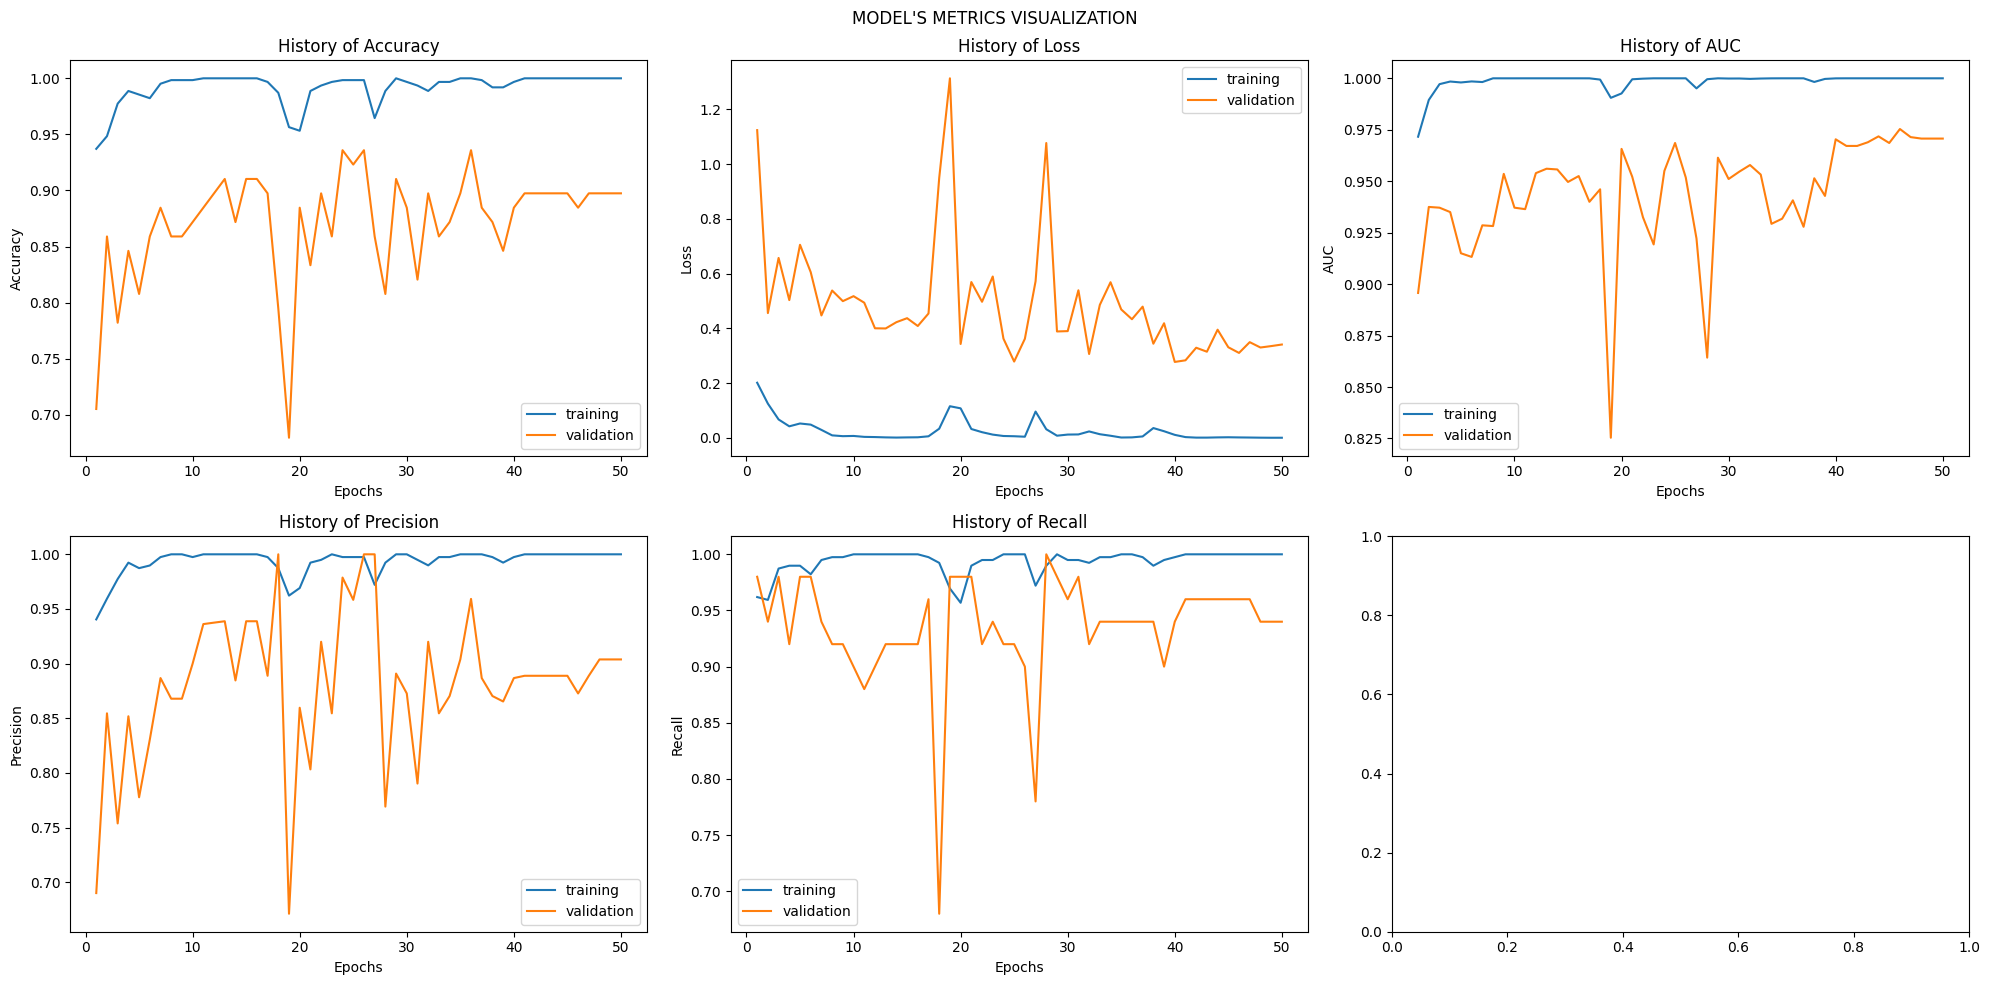

In [78]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, recall, val_recall):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    axes[0, 0].plot(range(1, len(acc) + 1), acc)
    axes[0, 0].plot(range(1, len(val_acc) + 1), val_acc)
    axes[0, 0].set_title('History of Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(['training', 'validation'])

    axes[0, 1].plot(range(1, len(loss) + 1), loss)
    axes[0, 1].plot(range(1, len(val_loss) + 1), val_loss)
    axes[0, 1].set_title('History of Loss')
    axes[0, 1].set_xlabel('Epochs')
    
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(['training', 'validation'])

    axes[0, 2].plot(range(1, len(auc) + 1), auc)
    axes[0, 2].plot(range(1, len(val_auc) + 1), val_auc)
    axes[0, 2].set_title('History of AUC')
    axes[0, 2].set_xlabel('Epochs')
    axes[0, 2].set_ylabel('AUC')
    axes[0, 2].legend(['training', 'validation'])

    axes[1, 0].plot(range(1, len(precision) + 1), precision)
    axes[1, 0].plot(range(1, len(val_precision) + 1), val_precision)
    axes[1, 0].set_title('History of Precision')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend(['training', 'validation'])

    axes[1, 1].plot(range(1, len(recall) + 1), recall)
    axes[1, 1].plot(range(1, len(val_recall) + 1), val_recall)
    axes[1, 1].set_title('History of Recall')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

# Call the function with your history data
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['recall'], history.history['val_recall'])

## Testing

# Dataset

In [79]:
model.load_weights("/kaggle/working/rimone_np_aug_fold4_densenet121_cbamcrm_nofinetuning.h5")
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
print("Accuracy", accuracy)
print("Loss", loss)
print("Precision", precision)
print("Recall", recall)
print("AUC", auc)
print("F1-score", (2*precision*recall/(precision+recall)))


4/4 [==============================] - 0s 60ms/step - loss: 0.0385 - accuracy: 0.9794 - precision: 0.9848 - recall: 0.9848 - auc: 0.9990
Accuracy 0.9793814420700073
Loss 0.038505636155605316
Precision 0.9848484992980957
Recall 0.9848484992980957
AUC 0.999022364616394
F1-score 0.9848484992980957


# Confusion Matrix for Dataset

/tmp/ipykernel_34/3818776088.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(X_test, 1157)


Confusion Matrix


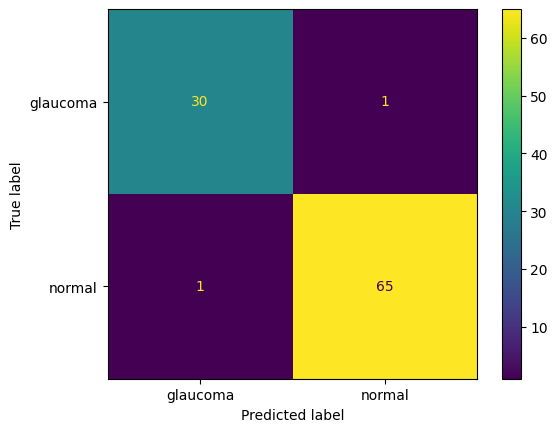

Classification Report
              precision    recall  f1-score   support

    glaucoma       0.97      0.97      0.97        31
      normal       0.98      0.98      0.98        66

    accuracy                           0.98        97
   macro avg       0.98      0.98      0.98        97
weighted avg       0.98      0.98      0.98        97

Precision macro: 0.9762952101661779
Recall macro: 0.9762952101661779
F1 score macro: 0.9762952101661779
Precision micro: 0.979381443298969
Recall micro: 0.979381443298969
F1 score micro: 0.979381443298969


In [80]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict_generator(X_test, 1157)
y_pred = np.where(y_pred > 0.5, 1, 0)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),display_labels=['glaucoma', 'normal'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['normal', 'glaucoma']
print(classification_report(y_test, y_pred, target_names=['glaucoma', 'normal']))

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred, labels=[0,1], average='macro')
recall = recall_score(y_test, y_pred, labels=[0,1], average='macro')
f1 = f1_score(y_test, y_pred, labels=[0,1], average='macro')
print("Precision macro:", precision)
print("Recall macro:", recall)
print("F1 score macro:", f1)
precision = precision_score(y_test, y_pred, labels=[0,1], average='micro')
recall = recall_score(y_test, y_pred, labels=[0,1], average='micro')
f1 = f1_score(y_test, y_pred, labels=[0,1], average='micro')
print("Precision micro:", precision)
print("Recall micro:", recall)
print("F1 score micro:", f1)